In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from omegaconf import OmegaConf
from os.path import join
from os import listdir
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# files
var_vocab_filepath = "../../process_pipeline/data/builds/dx_250415_200_mean_clip/output/variables_vocabulary.json"
pos_vocab_filepath = "../../process_pipeline/data/builds/dx_250415_200_mean_clip/output/position_vocabulary.json"
rating_filepath = "../../process_pipeline/data/builds/dx_250415_200_mean_clip/control/steps_selected.xlsx"

with open(var_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_var_dict = json.load(file)
    
with open(pos_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_pos_dict = json.load(file)
    
# maps
var_map = {v: k[:3] for k, v in inv_var_dict.items()}
pos_map = {v: int(float(k)) for k, v in inv_pos_dict.items()}
rate_map = pd.read_excel(rating_filepath).set_index("Step")["Bewertung "].to_dict()

In [3]:
var_map

{0: 'las',
 1: 'las',
 2: 'las',
 3: 'las',
 4: 'las',
 5: 'las',
 6: 'las',
 7: 'las',
 8: 'gal',
 9: 'gal',
 10: 'gal',
 11: 'gal',
 12: 'gal',
 13: 'gal',
 14: 'gal',
 15: 'gal',
 16: 'gal',
 17: 'gal',
 18: 'gal',
 19: 'gal',
 20: 'gal',
 21: 'gal',
 22: 'gal',
 23: 'gal',
 24: 'gal',
 25: 'gal',
 26: 'gal',
 27: 'gal',
 28: 'gal',
 29: 'gal',
 30: 'gal',
 31: 'gal',
 32: 'gal',
 33: 'gal',
 34: 'gal',
 35: 'gal',
 36: 'gal',
 37: 'gal',
 38: 'gal',
 39: 'gal',
 40: 'gal',
 41: 'gal',
 42: 'gal',
 43: 'gal',
 44: 'gal',
 45: 'gal',
 46: 'gal',
 47: 'gal',
 48: 'gal',
 49: 'gal',
 50: 'gal',
 51: 'gal',
 52: 'gal',
 53: 'gal',
 54: 'gal',
 55: 'gal',
 56: 'gal',
 57: 'gal',
 58: 'gal',
 59: 'gal',
 60: 'gal',
 61: 'gal',
 62: 'gal',
 63: 'gal',
 64: 'gal',
 65: 'gal',
 66: 'gal',
 67: 'gal',
 68: 'gal',
 69: 'gal',
 70: 'gal',
 71: 'gal',
 72: 'gal',
 73: 'gal',
 74: 'gal',
 75: 'gal',
 76: 'gal',
 77: 'gal',
 78: 'gal',
 79: 'gal',
 80: 'gal',
 81: 'gal',
 82: 'gal',
 83: 'gal',
 8

In [4]:
experiment_dirpath = "../experiments/training/test_optimizer_res/"
sweep_subpath = ""
ckpt_subpath = "k_0/checkpoints/"

working_dirpath = join(experiment_dirpath, sweep_subpath, ckpt_subpath)

regex_pattern = r"epoch=(\d+).*"

ckpt_dict = {}

for file in listdir(working_dirpath):
    match = re.search(regex_pattern, file)
    if match:
        file_path = join(working_dirpath, file)
        ckpt_dict[match.group(1)] = torch.load(file_path, map_location="cpu")["state_dict"]

print(ckpt_dict.keys())
ckpt_example = ckpt_dict[list(ckpt_dict.keys())[0]]

for k in ckpt_example.keys():
    print(k, ckpt_example[k].shape)

dict_keys([])


IndexError: list index out of range

In [119]:
key_list = [
    "model.enc_embedding.embed_modules_list.0.embedding.embedding.weight",
    "model.enc_embedding.embed_modules_list.1.embedding.embedding.weight"
    ]

In [125]:
ckpt_dict["99"]

OrderedDict([('model.enc_embedding.embed_modules_list.0.embedding.embedding.weight',
              tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                      [-1.6531,  0.0060,  1.3815,  ..., -0.8018,  0.3940,  2.5350],
                      [ 0.2491,  0.8971,  0.7805,  ..., -0.5307, -1.7913, -0.2864],
                      ...,
                      [-0.7719,  1.2371, -0.4051,  ...,  0.6983,  1.0838, -0.2302],
                      [ 0.4923,  0.5235,  0.2649,  ...,  1.5140, -0.9843, -2.5541],
                      [ 1.7586, -0.4463, -1.0573,  ..., -0.7076,  2.5612, -0.6067]])),
             ('model.enc_embedding.embed_modules_list.1.embedding.embedding.weight',
              tensor([[ 0.1391, -0.1082, -0.7174,  ...,  1.3107,  2.0405, -1.4052],
                      [-0.0063,  0.8454, -1.0847,  ..., -1.1029,  0.5053, -0.4422],
                      [ 0.3998,  0.2579,  0.9302,  ..., -0.3528, -0.3896,  1.0219],
                      ...,
                 

In [120]:
var_list = []
n_pca_comps = 3

full_dict = {}
for key in key_list:
    key_dict = {}
    
    for k in ckpt_dict.keys():
        epoch_dict = {}
        embeddings = ckpt_dict[k][key]
        pca = PCA(n_components=n_pca_comps)
        pcs = pca.fit_transform(embeddings)
        epoch_dict["explained_var"] = pca.explained_variance_ratio_
        epoch_dict["components"] = pcs
        key_dict[int(k)] = epoch_dict
    
    full_dict[key] = key_dict

pcs_var = full_dict[key_list[0]][199]["components"]
pcs_pos = full_dict[key_list[1]][199]["components"]


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [99]:
df_var = pd.DataFrame(pcs_var, columns=[f"PC{i}" for i in range(1, n_pca_comps + 1)])
df_var["process"]=df_var.index.map(var_map)
df_var

,PC1,PC2,PC3,process
0,-0.491697,0.001445,-2.397399,las
1,-1.131260,-0.348486,0.431111,las
2,0.400202,0.029119,0.760258,las
3,1.124077,-0.699846,-0.901922,las
4,0.198414,1.690498,0.038067,las
...,...,...,...,...
484,-0.890286,2.985622,0.120986,NaN
485,3.313908,1.459133,-1.187768,NaN
486,-0.380712,-0.842886,-1.097198,NaN
487,-0.809117,1.878628,2.098964,NaN


<Axes: xlabel='PC1', ylabel='PC2'>

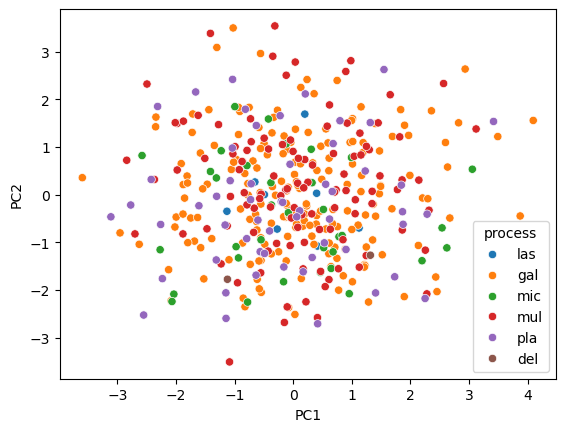

In [114]:
sns.scatterplot(data=df_var, x="PC1", y="PC2", hue="process")

In [107]:
df_pos = pd.DataFrame(pcs_pos, columns=[f"PC{i}" for i in range(1, n_pca_comps + 1)])
df_pos["rating"]=df_pos.index.map(pos_map).map(rate_map)
df_pos

,PC1,PC2,PC3,rating
0,-0.900623,0.871659,-0.402000,3
1,0.452209,0.460468,-1.584562,3
2,2.501332,3.661096,1.936272,0
3,-2.141362,-3.537153,2.874306,1
4,-0.484260,0.125690,1.193634,3
5,3.621056,-1.050518,-2.236672,0
6,4.194180,-0.462763,-0.188479,0
7,-1.575022,4.362376,1.143198,2
8,-0.628591,-2.399499,-1.246006,1
9,-1.789631,-0.181593,-2.579187,1


<Axes: xlabel='PC1', ylabel='PC2'>

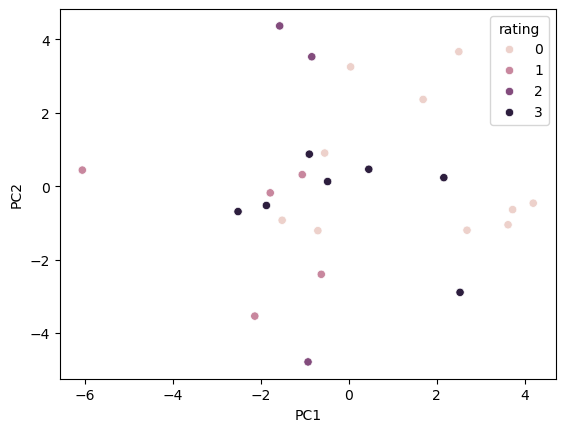

In [116]:
sns.scatterplot(data=df_pos, x="PC1", y="PC2", hue="rating")